## 예제 2.1 토큰화 코드

# Q1. 왜 토큰 아이디를 할당?
- 토큰을 임베딩으로 변환 후에 기존에 어떤 토큰을 변환했는지 고거를 매핑시킬라고.

In [16]:
# 띄어쓰기 단위로 분리
input_text = "나는 최근 파리 여행을 다녀왔다"
input_text_list = input_text.split()
print("input_text_list: ", input_text_list)

# 토큰 -> 아이디 딕셔너리와 아이디 -> 토큰 딕셔너리 만들기
str2idx = {word:idx for idx, word in enumerate(input_text_list)}
idx2str = {idx:word for idx, word in enumerate(input_text_list)}
print("str2idx: ", str2idx)
print("idx2str: ", idx2str)

# 토큰을 토큰 아이디로 변환
input_ids = [str2idx[word] for word in input_text_list]
print("input_ids: ", input_ids)

input_text_list:  ['나는', '최근', '파리', '여행을', '다녀왔다']
str2idx:  {'나는': 0, '최근': 1, '파리': 2, '여행을': 3, '다녀왔다': 4}
idx2str:  {0: '나는', 1: '최근', 2: '파리', 3: '여행을', 4: '다녀왔다'}
input_ids:  [0, 1, 2, 3, 4]


## 예제 2.2 토큰 아이디에서 벡터로 변환

# Code Description
- 임베딩 수행을 위해서 파이토치가 제공하는 nn.Embedding 클래스를 사용.
- 딕셔너리 크기와 임베딩 차원을 16차원 설정해서 토큰 하나를 16차원의 벡터로 변환.

# Q1. 왜 16차원 벡터로 변환한걸까?
- 일단 여기서는 그냥 테스트용 파라미터 값을 넣은 것. -> 그럼 임베딩 차원의 크기에 따른 의미가 존재할까?
- 임베딩의 차원 크기가 커지면 좀 더 복잡한 의미론적 관계를 표현할 수 있음. -> 뉘앙스나 미묘한 의미 차이.
- 근데 그럴수록 딕셔너리 크기가 커질꺼고 과적합 관련 문제 및 가용 메모리와 처리 능력에 따른 제한이 생길 수 있음.

In [17]:
import torch
import torch.nn as nn

embedding_dim = 16
embed_layer = nn.Embedding(len(str2idx), embedding_dim)

input_embeddings = embed_layer(torch.tensor(input_ids)) # (5, 16)
input_embeddings = input_embeddings.unsqueeze(0) # (1, 5, 16)
input_embeddings.shape

# 위 임베딩 층은 토큰의 의미를 담아서 벡터로 변환하지 않고 그저 토큰 아이디를 16차원 임의의 숫자 집합으로 변환.
# -> 임베딩 층이 단어의 의미를 담기 위해서는 딥러닝 모델이 학습 데이터로 훈련되어야 함.

# 딥러닝은 모델이 특정 작업을 잘 수행하도록 학습하는 과정에서 데이터의 의미를 잘 담은 임베딩을 만드는 방법도 함께 학습.

torch.Size([1, 5, 16])

## 예제 2.3 절대적 위치 인코딩

# Code Description
- 왜 텐서로 변환? -> 텐서가 파이토치의 기본 데이터 타입으로 다차원 배열을 표현. -> 여러 이점이 있는데 여기서는 벡터화 연산을 위해서 변환함.
- 왜 배치차원 추가함? -> 신경망은 일반적으로 배치 단위로 데이터를 처리하도록 설계 -> 모델이 예상하는 입력 형태 맞추기.
- 해당 코드 상에서는 토큰 아이디와 위치 아이디가 모두 0, 1, 2, 3, 4로 같지만 예시 데이터라서 같은 것이고 일반적으로는 같지 않음.

In [18]:
embedding_dim = 16
max_position = 12

# 위치 인코딩 층 생성
position_embed_layer = nn.Embedding(max_position, embedding_dim)
# 입력 시퀀스 길이만큼 위치 ID 생성 -> unsqueeze(0)으로 배치 차원 추가 ([0, 1, 2, 3, 4] -> [[0, 1, 2, 3, 4]])
position_ids = torch.arange(len(input_ids), dtype=torch.long).unsqueeze(0)
# 위치 인코딩 층을 통해서 위치 ID를 위치 인코딩으로 변환
position_encodings = position_embed_layer(position_ids)

# 토큰 임베딩 층 생성
embed_layer = nn.Embedding(len(str2idx), embedding_dim)
token_embeddings = embed_layer(torch.tensor(input_ids)) # (5, 16)
token_embeddings = token_embeddings.unsqueeze(0) # (1, 5, 16)
# 토큰 임베딩과 위치 인코딩을 더해 최종 입력 임베딩 생성
input_embeddings = token_embeddings + position_encodings
input_embeddings.shape

torch.Size([1, 5, 16])

## 예제 2.4 쿼리, 키, 값 벡터를 만드는 nn.Linear 층

# Code Description
- 딥러닝에서 특정 기능을 더 잘 수행하기 싶으면 가중치를 부여하고 학습을 통해서 업데이트 하는 형식 추구.
- 쿼리, 키, 값에 대한 가중치를 부여해서 각각에 대한 가중치를 부여해서 토큰 간 관계 이해 및 주변 맥락 반영을 수행하도록 학습시킴.

# Q1. 근데 왜 굳이 키와 값에 대한 가중치를 독립적으로 부여한걸까? 어짜피 같은 값을 이용하지 않나?
- 일단 키는 검색 or 매칭을 위한 표현이고 쿼리와의 유사도를 계산하여 어떤 정보에 집중할지 결정하는 역할이고 값은 실제로 전달될 정보의 표현임. -> 역할 분리하여 각 역할에 최적화된 표현 공간을 학습.
- 단일 임베딩으로는 '어떤 정보와 연관되는지'와 '어떤 정보를 전달할지'를 동시에 최적화 하기 어려움. -> 분리하여 독립적으로 최적화.
### 수학적 관점
- 어텐션 스코어: Attention(Q, K) = softmax(QK^T/√d)
- 출력: Output = Attention(Q, K, V) = softmax(QK^T/√d)V
- 만약 여기서 K와 V가 동일하다면 '유사도 측정 공간'과 '정보 표현 공간'이 동일해지고 이는 모델의 표현력을 제한함.

In [19]:
head_dim = 16

# 쿼리, 키, 값을 계산하기 위한 변환
weight_q = nn.Linear(embedding_dim, head_dim) # 쿼리 가중치
weight_k = nn.Linear(embedding_dim, head_dim) # 키 가중치
weight_v = nn.Linear(embedding_dim, head_dim) # 값(토큰 임베딩) 가중치
# 변환 수행
querys = weight_q(input_embeddings) # (1, 5, 16)
keys = weight_k(input_embeddings) # (1, 5, 16)
values = weight_v(input_embeddings) # (1, 5, 16)

## 예제 2.5. 스케일 점곱 방식의 어텐션

# Code Description
- 스코어를 쿼리 벡터 값과 키 벡터 사이의 행렬 곱을 통한 내적을 구하여 유사도를 계산함.
- 해당 유사도 스코어 벡터를 그대로 보면 [10.3, -2.3, ...] 이렇게 나오는데 이를 낮은 값은 더 낮게 높은 값은 더 높게 만들기 위해서 소프트맥스를 하면 합이 1이 되는 확률값으로 바뀜.
- 여기에서 각각의 값들과 이 가중치들의 곱한 값들의 합 -> 가중합을 계산하면 새로운 토큰 임베딩이 나오고 이는 쿼리에 대한 새로운 임베딩 값이 됨.
- 그리고 추후에 모델의 출력과 실제 값 사이의 손실을 계산해서 역전파 알고리즘을 사용해 각 가중치가 손실에 미치는 영향(그래디언트)를 계산하고 이를 이용해서 가중치 업데이트.
- 이 과정에서 그래디언트가 너무 커지는 문제가 발생할 수 있기 때문에 정규화 필요.

In [20]:
from math import sqrt
import torch.nn.functional as F

def compute_attention(querys, keys, values, is_causal=False):
    """
	스케일 점곱 어텐션 함수
	PARAMS
	- querys: 쿼리 텐서(벡터)
	- keys: 키 텐서(벡터)
	- values: 값 텐서(벡터)
	- is_causal: 마스킹 여부
	"""

    dim_k = querys.size(-1)  # 16, 마지막 차원 가져오기
    # 키 행렬의 마지막 두 차원을 전치해서 행렬 곱이 가능하게 만듬.
    # 행렬 곱셈을 통한 내적 계산 후 스케일링 작업
    # 	- 내적 계산: 쿼리와 키 사이의 유사도 계산
    # 	- 스케일링: 차원이 커질수록 내적 값의 분산이 커져서 소프트맥스 함수가 매우 작은 기울기를 가지게 됨 -> 이를 방지.
    scores = (
        querys @ keys.transpose(-2, -1) / sqrt(dim_k)
    )
    # 시퀀스 길이 차원에 대해 소프트맥스 함수 적용.
    # - 확률 분포 생성: 스코어를 0~1 사이의 확률값으로 변환 후 합이 1이 되도록 정규화. -> 낮은 값은 더 낮게 높은 값은 더 높게 만들어서 집중도를 높임.
    # - 그리고 역전파를 통한 학습이 가능 -> 소프트맥스 함수의 출력값을 손실 함수로 사용하여 가중치 업데이트.
    weights = F.softmax(scores, dim=-1)
    # 가중합 계산.
    # - 가중치를 곱한 값들의 합계, output = ∑(weight_i * value_i)
    return weights @ values

## 예제 2.6. 어텐션 연산의 입력과 출력

In [21]:
print("원본 입력 형태: ", input_embeddings.shape)
print("원본 값 임베딩: ", values)

after_attention_embeddings = compute_attention(querys, keys, values)

print("어텐션 적용 후 형태: ", after_attention_embeddings.shape)
print("어텐션 적용 후 값 임베딩: ", after_attention_embeddings)
# 원본 입력 형태:  torch.Size([1, 5, 16])
# 어텐션 적용 후 형태:  torch.Size([1, 5, 16])
# 값 임베딩을 살펴보면 값이 바뀌고 엄청 작아진걸 확인할 수 있음. -> 합이 1이 되도록 정규화되어서 값이 작아짐.

원본 입력 형태:  torch.Size([1, 5, 16])
원본 값 임베딩:  tensor([[[-1.4834, -0.7453,  0.3188,  0.3325,  0.3646,  1.0704, -1.2318,
           0.5179,  0.4127, -0.0194,  0.6072, -0.9946, -1.1823,  0.0995,
          -0.6857, -0.6542],
         [ 0.0758, -1.4379, -0.1730,  0.2645, -0.5365, -1.0900, -0.2541,
           0.6921, -0.4283,  0.1186, -0.1353, -0.3973,  0.2876, -0.9536,
          -0.6114,  1.8628],
         [-0.8358,  0.3472, -0.0521,  0.4362, -1.2461, -0.2543, -0.7973,
          -0.1542,  1.0548, -0.2189,  1.8342, -0.3259, -0.9245, -0.7178,
           0.7705,  0.0230],
         [ 0.4473,  0.1334, -0.2567, -1.7673,  0.0032, -1.4029,  1.4778,
          -0.3102, -0.0219,  0.2454, -0.3446,  1.4138,  0.0369, -1.0875,
           1.1860,  0.3845],
         [-0.3807, -0.4247, -0.5248,  1.0241, -0.4570,  1.1248, -0.5220,
          -0.7620,  0.0656, -1.5901, -0.1620,  0.4374, -0.3348, -0.1572,
          -0.6000, -1.0422]]], grad_fn=<ViewBackward0>)
어텐션 적용 후 형태:  torch.Size([1, 5, 16])
어텐션 적용 후 값 임베딩: 

## 예제 2.7. 어텐션 연산을 수행하는 AttentionHead 클래스

In [22]:
class AttentionHead(nn.Module):
  def __init__(self, token_embed_dim, head_dim, is_causal=False):
    super().__init__()
    self.is_causal = is_causal
    self.weight_q = nn.Linear(token_embed_dim, head_dim) # 쿼리 벡터 생성을 위한 선형 층
    self.weight_k = nn.Linear(token_embed_dim, head_dim) # 키 벡터 생성을 위한 선형 층
    self.weight_v = nn.Linear(token_embed_dim, head_dim) # 값 벡터 생성을 위한 선형 층

  def forward(self, querys, keys, values):
    outputs = compute_attention(
        self.weight_q(querys),  # 쿼리 벡터
        self.weight_k(keys),    # 키 벡터
        self.weight_v(values),  # 값 벡터
        is_causal=self.is_causal
    ) # 스케일 점곱 어텐션 수행.
    return outputs

attention_head = AttentionHead(embedding_dim, embedding_dim)
after_attention_embeddings = attention_head(input_embeddings, input_embeddings, input_embeddings)

## 예제 2.8. 멀티 헤드 어텐션 구현

In [23]:
class MultiheadAttention(nn.Module):
  def __init__(self, token_embed_dim, d_model, n_head, is_causal=False):
    super().__init__()
    self.n_head = n_head
    self.is_causal = is_causal
    self.weight_q = nn.Linear(token_embed_dim, d_model)
    self.weight_k = nn.Linear(token_embed_dim, d_model)
    self.weight_v = nn.Linear(token_embed_dim, d_model)
    self.concat_linear = nn.Linear(d_model, d_model)

  def forward(self, querys, keys, values):
    B, T, C = querys.size()
    # 쿼리, 키, 값에 대한 가중치 벡터를 생성하고 헤드의 개수로 나눈 후 차원을 바꿈. -> 의미는 필기 참조.
    querys = self.weight_q(querys).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (1, 5, 16) -> (1, 5, 4, 4) -> (1, 4, 5, 4)
    keys = self.weight_k(keys).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (1, 5, 16) -> (1, 5, 4, 4) -> (1, 4, 5, 4)
    values = self.weight_v(values).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (1, 5, 16) -> (1, 5, 4, 4) -> (1, 4, 5, 4)
    # 스케일 점곱 어텐션 수행.
    attention = compute_attention(querys, keys, values, self.is_causal)
    # 헤드 차원을 다시 원래대로 바꾸고 연결 후 선형 변환 수행.
    # - contiguous(): 메모리 상에 텐서를 연속적인 공간으로 할당해서 연산을 효율적으로 수행.
    # - view(): 텐서의 모양을 바꿔주는 함수. -> 기존 차원으로 변경.
    output = attention.transpose(1, 2).contiguous().view(B, T, C) # (1, 4, 5, 4) -> (1, 5, 4, 4) -> (1, 5, 16)
    # 선형 변환 수행.
    # - 위에서 원래 차원으로 변경했지만 이는 단순히 숫자들이 원래 차원으로 맞춰진 것.
    # - 각 헤드는 의미적으로 다른 정보 (예: 의미 관계, 문맥적 패턴, 구조적 패턴 등)을 포착해 어텐션 결과가 달라짐.
    # - 이는 단순히 차원을 돌린다고 원래 의미로 복원될 수 없음을 의미함. -> 각 헤드의 출력을 적절히 조합하고 필터링하는 과정이 필요함.
    # - 이 역할을 선형 변환이 수행하는데 가중치 행렬을 이용함. (딥러닝에선 특정 기능을 잘하게 하기 위해 가중치를 사용한다고 했었음.)
    # - X: output, W: 가중치 행렬, b: 편향 벡터, y = XW^T + b
    output = self.concat_linear(output)
    return output

n_head = 4
mh_attention = MultiheadAttention(embedding_dim, embedding_dim, n_head)
after_attention_embeddings = mh_attention(input_embeddings, input_embeddings, input_embeddings)
after_attention_embeddings.shape

torch.Size([1, 5, 16])

## 예제 2.9. 층 정규화 코드

In [24]:
norm = nn.LayerNorm(embedding_dim)
norm_x = norm(input_embeddings)
norm_x.shape # torch.Size([1, 5, 16])

norm_x.mean(dim=-1).data, norm_x.std(dim=-1).data

# (tensor([[ 2.2352e-08, -1.1176e-08, -7.4506e-09, -3.9116e-08, -1.8626e-08]]),
#  tensor([[1.0328, 1.0328, 1.0328, 1.0328, 1.0328]]))

(tensor([[ 0.0000e+00, -1.8626e-08,  2.9802e-08, -7.4506e-09, -1.4901e-08]]),
 tensor([[1.0328, 1.0328, 1.0328, 1.0328, 1.0328]]))

## 예제 2.10. 피드 포워드 층 코드

In [25]:
class PreLayerNormFeedForward(nn.Module):
  def __init__(self, d_model, dim_feedforward, dropout):
    super().__init__()
    # 선형 변환 -> y = ax + b 형태로 표현되는 선형 변환을 수행, 변환 후에도 구조가 유지됨.
    self.linear1 = nn.Linear(d_model, dim_feedforward) # 선형 층 1 -> 정보 손실을 줄이고 복잡한 더 풍부한 표현을 위해 차원을 늘림.
    self.linear2 = nn.Linear(dim_feedforward, d_model) # 선형 층 2
    # 뉴런들이 특정 패턴만 학습하는 것을 방지하고, 모델이 더 일반적인 특징을 학습하도록 유도하는 방법.
    # 왜 랜덤으로 제거한다고 과적합이 방지? -> 랜덤으로 제거함으로써 특정 뉴런이 혼자서 너무 강한 영향력을 가지는 것을 막고, 신경망이 다양한 특징을 학습하도록 유도.
    # - 과적합이 발생하는 이유 -> 신경망이 너무 복잡하면, 훈련 데이터의 특정 패턴(노이즈 포함)을 지나치게 학습. -> 일반화 성능 낮아짐.
    self.dropout1 = nn.Dropout(dropout) # 드랍아웃 층 1 -> 뉴런의 일부를 무작위로 제거(0으로 만듦)하여 과적합 방지.
    self.dropout2 = nn.Dropout(dropout) # 드랍아웃 층 2
    # 비선형 변환 -> y = x^2와 같이 곡선으로 표현되며, 입출력 간의 관계를 더 복잡하게 표현할 수 있음. -> 복잡한 관계 학습 가능.
    # - 선형 변환만으로는 딥러닝이 제대로 동작하지 않음 -> 아무리 층을 쌓아도 결국 하나의 선형 함수로 축약됨. -> 신경망이 깊어져도 하나의 y = Wx + b로 표현됨.
    #   => 비선형성을 추가해야 층을 쌓는 것이 의미를 가짐.
    self.activation = nn.GELU() # 활성 함수 -> 뉴런의 출력을 결정하는 함수. (GELU: Gaussian Error Linear Unit)
    self.norm = nn.LayerNorm(d_model) # 층 정규화

  def forward(self, src):
    x = self.norm(src)
    # 드랍아웃을 통해서 미리 뉴런을 끄고 연산을 진행하는 것이 아니라, 연산을 진행하고 나온 결과값을 랜덤하게 0으로 만들고 다음 학습을 진행.
    #  => 드롭아웃은 특정 변환 이후에 적용되며, 해당 변환의 출력 값에 영향을 주는 방식.
    x = x + self.linear2(self.dropout1(self.activation(self.linear1(x))))
    x = self.dropout2(x)
    return x

## 예제 2.11. 인코더 층

In [26]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, d_model, nhead, dim_feedforward, dropout):
    super().__init__()
    self.attn = MultiheadAttention(d_model, d_model, nhead) # 멀티 헤드 어텐션 클래스
    self.norm1 = nn.LayerNorm(d_model) # 층 정규화
    self.dropout1 = nn.Dropout(dropout) # 드랍아웃
    self.feed_forward = PreLayerNormFeedForward(d_model, dim_feedforward, dropout) # 피드포워드

  def forward(self, src):
    norm_x = self.norm1(src)
    attn_output = self.attn(norm_x, norm_x, norm_x)
    x = src + self.dropout1(attn_output) # 잔차 연결

    # pre layer norm 수행하는 피드 포워드 층 -> 그래서 따로 정규화 층이 없음.
    x = self.feed_forward(x)
    return x

## 예제 2.12. 인코더 구현

# 위 인코더 레이어가 Ne번 반복되도록 코드 구현
- 입력한 모듈을 깊은 복사를 통해 N번 반복해 모듈 리스트에 삽입.
- 

In [27]:
import copy
def get_clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class TransformerEncoder(nn.Module):
  def __init__(self, encoder_layer, num_layers):
    super().__init__()
    self.layers = get_clones(encoder_layer, num_layers) # N번 반복.
    self.num_layers = num_layers
    self.norm = norm

  def forward(self, src):
    output = src
    for mod in self.layers:
        output = mod(output)
    return output

## 예제 2.13. 디코더에서 어텐션 연산(마스크 어텐션)

# Q1. 왜 대각선 위를 마스킹하는지?
- Self-Attention 연산에서는 쿼리 토큰이 키 토큰을 얼마나 참고할지 결정해야함. -> 즉, Attention 스코어 행렬의 (i, j) 위치는 다음을 의미함.
    - i: 쿼리의 시점 (현재 위치)
    - j: 키의 시점 (참조하는 과거/현재/미래 위치)
    => (i, j) 값은 "i번째 쿼리가 j번째 키를 얼마나 참고하는지"를 나타냄.
- 쿼리는 현재 시점이고 키는 참조할 시점이라고 했음.
    - 쿼리가 "파리에"라면 키는 "나는", "파리에", "간다"임.
    - 근데 (i, j)의 의미를 위와 같이 설명했다면 i번째 쿼리에서는 i보다 큰 j를 보면 안됨. -> 미래 시점의 토큰임.
    - 그래서 쿼리는 대각선까지만 확인하고 그 위로는 확인하면 안됨. -> 그 위는 i와 미래 토큰 간의 연관 관계에 대한 데이터이기 때문.
    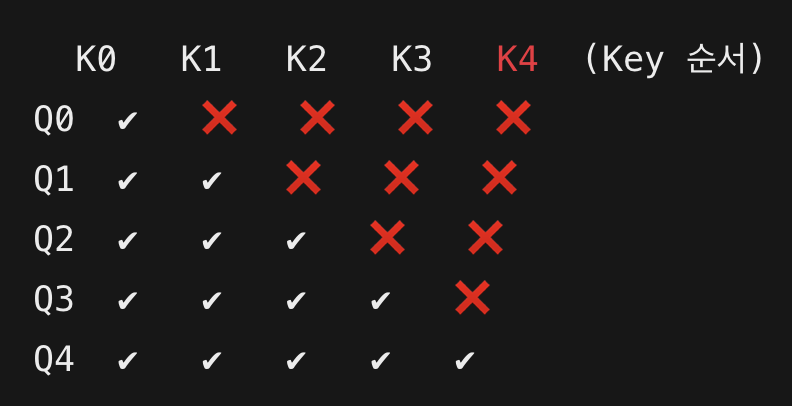


In [29]:
def compute_attention(querys, keys, values, is_causal=False):
	dim_k = querys.size(-1) # 16
	scores = querys @ keys.transpose(-2, -1) / sqrt(dim_k) # (1, 5, 5)
	if is_causal: # 인과적 어텐션 -> 현재 시점 이전의 시점에만 집중하도록 마스킹.
		query_length = querys.size(-2)
		print(query_length)
		key_length = keys.size(-2)
		print(key_length)
		temp_mask = torch.ones(query_length, key_length, dtype=torch.bool).tril(diagonal=0)
		scores = scores.masked_fill(temp_mask == False, float("-inf"))
	weights = F.softmax(scores, dim=-1) # (1, 5, 5)
	return weights @ values # (1, 5, 16)

compute_attention(querys, keys, values, is_causal=True)

5
5


tensor([[[-1.4834, -0.7453,  0.3188,  0.3325,  0.3646,  1.0704, -1.2318,
           0.5179,  0.4127, -0.0194,  0.6072, -0.9946, -1.1823,  0.0995,
          -0.6857, -0.6542],
         [-0.8372, -1.0323,  0.1150,  0.3043, -0.0089,  0.1750, -0.8266,
           0.5901,  0.0642,  0.0378,  0.2994, -0.7471, -0.5731, -0.3370,
          -0.6549,  0.3890],
         [-1.1788, -0.6151,  0.1907,  0.3446, -0.0493,  0.5661, -1.0353,
           0.4087,  0.4392, -0.0418,  0.7575, -0.7970, -0.9630, -0.1793,
          -0.3970, -0.2333],
         [-0.2574, -0.1571, -0.1223, -0.3517, -0.5763, -0.7286,  0.0559,
           0.0076,  0.3482,  0.0196,  0.6182,  0.2063, -0.3692, -0.8388,
           0.5380,  0.4757],
         [-1.0013, -0.6348,  0.0193,  0.5021, -0.0268,  0.8224, -0.9054,
           0.1257,  0.2851, -0.4560,  0.3961, -0.4849, -0.8084, -0.1100,
          -0.5521, -0.5263]]], grad_fn=<UnsafeViewBackward0>)

## 예제 2.14. 크로스 어텐션이 포함된 디코더 층

# Q1. 크로스 어텐션에서 값에도 인코더의 결과 값을 이용하는 이유.
- 어텐션의 역할은 디코더가 참고할 정보를 선택하는 것.
- 디코더는 출력 문장을 만들기 위해서 어떤 문장의 어떤 부분이 중요한지 알고 싶음.
- 쿼리 = "다음 단어를 생성하는데 필요한 정보가 뭐야?"
- 키 = "인코더가 저장한 모든 정보 중에서 가장 관련 있는 건 뭐야?"
- 값 = "그럼 이 정보를 가중합해서 가져가!"

# Q2. 왜 순전파 코드에서 잔차 연결을 tgt가 아닌 x와 하는지.
- 잔차 연결의 목적은 "원래 정보가 손실되지 않도록 보존하는 것".
- 그렇기에 어텐션에 input으로 들어가는 값을 이용하여 잔차연결에 활용함.

In [30]:
class TransformerDecoderLayer(nn.Module):
  def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
    super().__init__()
    self.self_attn = MultiheadAttention(d_model, d_model, nhead)
    self.multihead_attn = MultiheadAttention(d_model, d_model, nhead)
    self.feed_forward = PreLayerNormFeedForward(d_model, dim_feedforward, dropout)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, tgt, encoder_output, is_causal=True):
    # 셀프 어텐션 연산 -> 지금까지 생성된 단어들끼리 연관성을 학습.
    x = self.norm1(tgt)
    x = x + self.dropout1(self.self_attn(x, x, x, is_causal=is_causal))
    # 크로스 어텐션 연산 -> 인코더에서 생성된 정보를 참고해서 중요 부분을 찾음.
    x = self.norm2(x)
    x = x + self.dropout2(self.multihead_attn(x, encoder_output, encoder_output))
    # 피드 포워드 연산 -> 입력 텍스트 전체 (생성된 단어 텍스트들 전체)를 이해하고 다음 단어를 결정할 준비를 함.
    x = self.feed_forward(x)
    return x
    # 디코더의 마지막 층을 통과한 결과를 최종 단어 분포(logits)로 변환.
    # Softmax를 적용해 가장 확률이 높은 단어를 선택 -> 선택된 단어를 다시 디코더 입력으로 넣어 반복.

## 예제 2.15. 디코더 구현

In [31]:
import copy
def get_clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class TransformerDecoder(nn.Module):
  def __init__(self, decoder_layer, num_layers):
    super().__init__()
    self.layers = get_clones(decoder_layer, num_layers)
    self.num_layers = num_layers

  def forward(self, tgt, src):
    output = tgt
    for mod in self.layers:
        output = mod(tgt, src)
    return output